In [1]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.paths import Experiment

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load paths to each set of experiments
path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/'
genotype = 'w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
exp = Experiment(os.path.join(path, genotype))

In [116]:
layers_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/layers.xlsx'
dtype = dict(experiment=str, disc_genotype=str, disc_id=int, layer=int, include=bool, region=str)
layers_df = pd.read_excel(layers_path, usecols=6, dtype=dtype)
layers_df.ix[layers_df.include==0, 'region'] = 'n'
df = layers_df[layers_df.disc_genotype==genotype]

In [32]:
with PdfPages('mutants.pdf') as pdf:    
    for disc_id in exp.disc_names:
        stack = exp.discs[disc_id].load_stack()
        fig = show_stack(stack, df)
        pdf.savefig(fig, dpi=300)
        plt.close()

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec


def show_stack(stack, df):
    disc_df = df[df.disc_id==disc_id]
    layers = disc_df[disc_df.include].layer.values
    
    fig = plt.figure(figsize=(6.75, 2.25*len(layers)))
    gs = GridSpec(nrows=len(layers), ncols=3, wspace=.01, hspace=.01)
    
    i = 0
    for layer_id in layers:
        include = df[np.logical_and(df.disc_id==disc_id, df.layer==layer_id)].include.values[0]
        if include:
            axes = fig.add_subplot(gs[i*3]), fig.add_subplot(gs[i*3+1]), fig.add_subplot(gs[i*3+2])            
            layer = stack.load_layer(layer_id)
            show_layer(layer, axes)
            if i == 0:
                axes[0].set_title('DAPI', fontsize=14)
                axes[1].set_title('UbiRFP', fontsize=14)
                axes[2].set_title('PntGFP', fontsize=14)
            
            i += 1
        
    return fig
    

def show_layer(layer, axes):
    layer.set_foreground(bandwidth=100, n=4)
            
    ax0, ax1, ax2 = axes
    _ = layer.get_channel('b').show(segments=False, ax=ax0, vmin=0, vmax=1)
    _ = layer.get_channel('r').show(segments=False, ax=ax1, vmin=0, vmax=1)
    _ = layer.get_channel('g').show(segments=False, ax=ax2, vmin=0, vmax=1)
    
    for ax in (ax1, ax2):
        layer.fg_mask.add_contourf(ax, alpha=.5)
    for ax in axes:
        ax.set_aspect(1)
    
    plt.tight_layout()

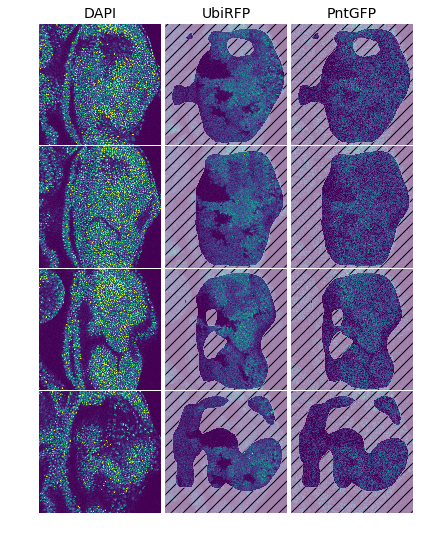

In [31]:
_ = show_stack(stack, df)

In [88]:
from modules.background import BackgroundCorrection

In [100]:
stack = exp[0]
layer = stack[0]

In [110]:
corr = BackgroundCorrection(layer, xvar='r', yvar='g', niters=10)
layer.df['g_rescaled'] = corr.yc

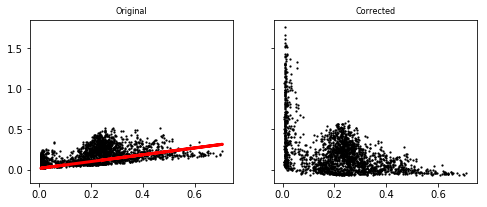

In [111]:
corr.show_correction()

In [112]:
layer.df['red'] = layer.df.r/layer.df.b
layer.df['green'] = layer.df.g_rescaled/layer.df.b

In [105]:
from scipy.stats import linregress

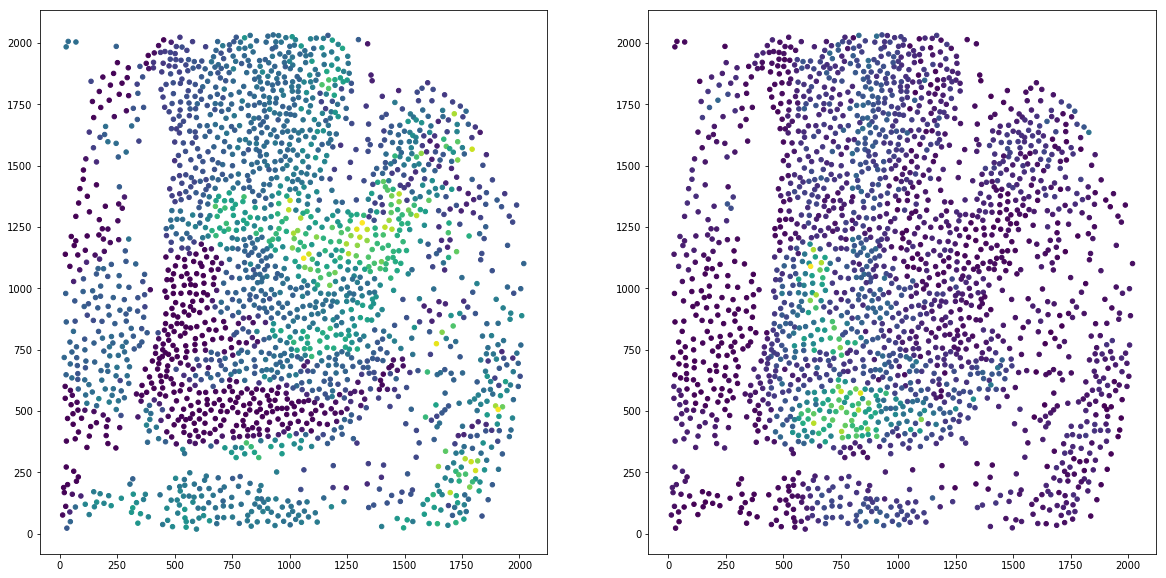

In [130]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20,10))

pts = layer.df[['centroid_y', 'centroid_x']].values

ax0.scatter(*pts.T, c=layer.df.r.values, s=20)
ax1.scatter(*pts.T, c=layer.df.g_rescaled.values, s=20)